In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [9]:
os.chdir('/input file path/')

In [10]:
var = pd.read_excel('acftest.xlsx')

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [12]:
# Stationarity test on the original Series using Augmented Dickey-Fuller (ADF) test
augdft= adfuller(var['daily'])

In [13]:
# Second argument below has a value of 0.0936817.. indicating the test failed to reject null hypothesis at 5%
print(augdft[0]) # Test Statistic
print(augdft[1]) # p-value
print(augdft[2])
print(augdft[3])
print(augdft[4])
print(augdft[5])

-2.5966975666982393
0.09368173602064722
0
67
{'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}
-369.62876826390766


In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

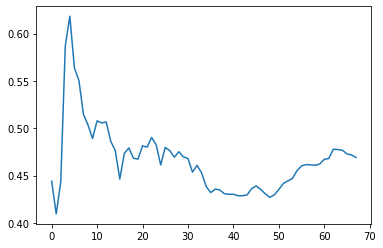

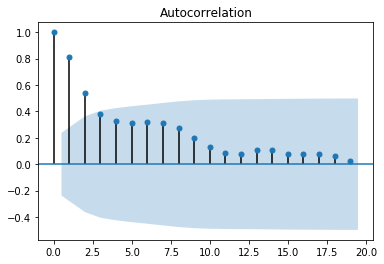

In [15]:
# Original Series plot
plt.plot(var['daily'])

# AutoCorrelation plot on the Original Series
plot_acf(var['daily']);

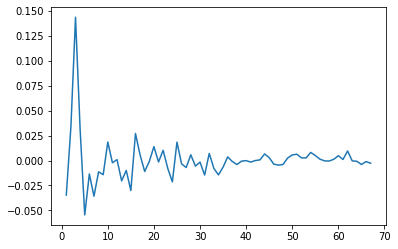

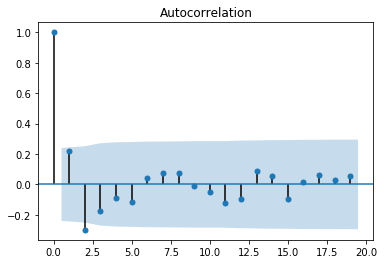

In [16]:
# First Difference plot of the Original Series
plt.plot(var['daily'].diff())

# AutoCorrelation plot on the Difference of Original Series
plot_acf(var['daily'].diff().dropna());

In [17]:
# Stationarity test on the Difference of Original Series
augdft1= adfuller(var['daily'].diff().dropna())

In [18]:
# Second argument of 0.0212284 indicate the test rejecting null hypothesis
# Indicating series satisfies stationarity condition as per ADF test
print(augdft1[0])
print(augdft1[1])
print(augdft1[2])
print(augdft1[3])
print(augdft1[4])
print(augdft1[5])

-3.179071990011865
0.02122848552759448
11
55
{'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
-360.1335841475066


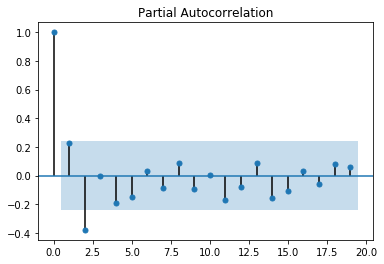

In [19]:
# Determine AR lag in ARIMA by plotting Partial AutoCorrelation
plot_pacf(var['daily'].diff().dropna());

In [20]:
# Determine MA Lag in ARIMA
# Can look at the AutoCorrelation plot to infer

In [21]:
# Fitting the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

In [22]:
# ARIMA model with AR lag of 2 and first difference. Here MA component is not considered
arimaMod = ARIMA(var['daily'], order=(2,1,0))

In [23]:
arimaModFit = arimaMod.fit()

In [24]:
# p-values for the AR coef below indicates significance
print(arimaModFit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.daily   No. Observations:                   67
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 166.590
Method:                       css-mle   S.D. of innovations              0.020
Date:                Fri, 28 May 2021   AIC                           -325.181
Time:                        00:51:46   BIC                           -316.362
Sample:                             1   HQIC                          -321.691
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.002      0.098      0.922      -0.004       0.005
ar.L1.D.daily     0.3359      0.115      2.917      0.005       0.110       0.562
ar.L2.D.daily    -0.4024      0.115     

In [25]:
# residual plots
rsd = pd.DataFrame(arimaModFit.resid)

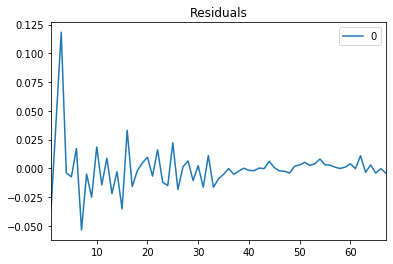

In [26]:
rsd.plot(title="Residuals")

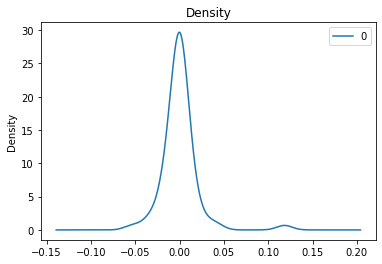

In [27]:
# Plotting the Kernel Density Estimation --> A Non-parametric estimate of the Gaussian PDF
rsd.plot(kind='kde', title='Density')

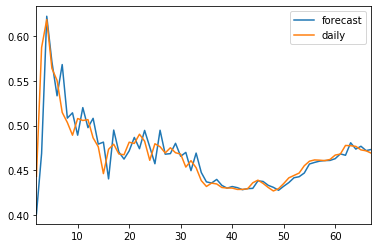

In [28]:
arimaModFit.plot_predict(dynamic=False);
#dynamic=False -> the model uses sample till previous value to predict

In [29]:
#Forecasting with training and testing sets
X = pd.DataFrame(var['daily'])

In [30]:
X.size

68

In [31]:
k = 0.8*X.size
k

54.400000000000006

In [32]:
# Thumb rule of 80:20 for training and testing. Can experiment cross-validation using different date range buckets
traindata = X[0:54]
testdata = X[54:]

In [34]:
print(traindata.size)
print(testdata.size)

54
14


In [35]:
arimaMod1 = ARIMA(traindata, order=(2,1,0))
arimaModFit1 = arimaMod1.fit()

In [36]:
arimaPrediction = arimaModFit.forecast(14,alpha=0.05) #95% confidence
print(arimaPrediction[0]) #predicted
print(arimaPrediction[1]) #SE
print(arimaPrediction[2]) #Confidence Interval

[0.46891965 0.47014696 0.47089618 0.4708963  0.47083721 0.47105971
 0.47140061 0.47166795 0.47186295 0.47206324 0.47229443 0.47253386
 0.47276363 0.47298683]
[0.02007176 0.03349372 0.03953261 0.04277426 0.04606822 0.04992602
 0.05365409 0.05689472 0.05983331 0.06268005 0.06546488 0.06813882
 0.0706895  0.07314303]
[[0.42957972 0.50825958]
 [0.40450046 0.53579345]
 [0.39341369 0.54837868]
 [0.38706028 0.55473232]
 [0.38054517 0.56112925]
 [0.3732065  0.56891291]
 [0.36624052 0.57656069]
 [0.36015635 0.58317955]
 [0.3545918  0.58913409]
 [0.34921259 0.59491388]
 [0.34398561 0.60060324]
 [0.33898422 0.6060835 ]
 [0.33421476 0.6113125 ]
 [0.32962912 0.61634455]]


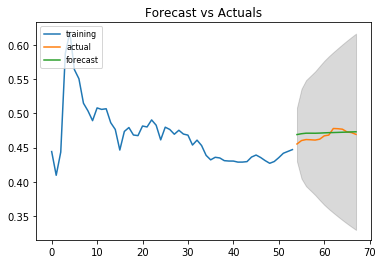

In [37]:
fSeries = pd.Series(arimaPrediction[0], index=testdata.index)
ls = pd.Series(arimaPrediction[2][:, 0], index=testdata.index)
us = pd.Series(arimaPrediction[2][:, 1], index=testdata.index)

#plot
plt.plot(traindata, label='training')
plt.plot(testdata, label='actual')
plt.plot(fSeries, label='forecast')
plt.fill_between(ls.index, ls, us, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)